# AAPL Price Action Analysis

I recently performed an exploratory data analysis on a stock price action dataset. One of the tickers was *AAPL*. I am going to explore month over month (MoM) price action action of *AAPL* using both **Python** and **SQL**

In [1]:
# importing packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
# reading in dataset

df = pd.read_csv(r"C:\Users\togarro\Downloads\Stocks.csv")

In [7]:
# shape of df

df.shape

(248, 8)

The dataset contains 248 rows and 8 columns.

In [9]:
# null values

df.isna().any()

Ticker       False
Date         False
Open         False
High         False
Low          False
Close        False
Adj_Close    False
Volume       False
dtype: bool

There are no null values.

In [8]:
df['Ticker'].unique()

array(['AAPL', 'MSFT', 'NFLX', 'GOOG'], dtype=object)

The dataset contains four unique 'Ticker' values.

In [13]:
# converting date column to ISO 8601 format (YYYY-MM-DD)

df['Date'] = pd.to_datetime(df['Date'])

In [15]:
# Date Range

most_recent = df['Date'].max()
least_recent = df['Date'].min()

range = most_recent - least_recent

print(most_recent)
print(least_recent)
print(range)

2023-05-05 00:00:00
2023-02-07 00:00:00
87 days 00:00:00


The dataset contains price data of the stock market for a total of 87 days beginning in February 7, 2023 and ending in May 5, 2023.

In [17]:
# Statistical Metrics AAPL

AAPL = df.query('Ticker == "AAPL"')

AAPL['Close'].describe()

count     62.000000
mean     158.240645
std        7.360486
min      145.310000
25%      152.077500
50%      158.055000
75%      165.162500
max      173.570000
Name: Close, dtype: float64

<Axes: title={'center': 'AAPL Boxplot'}, ylabel='Price'>

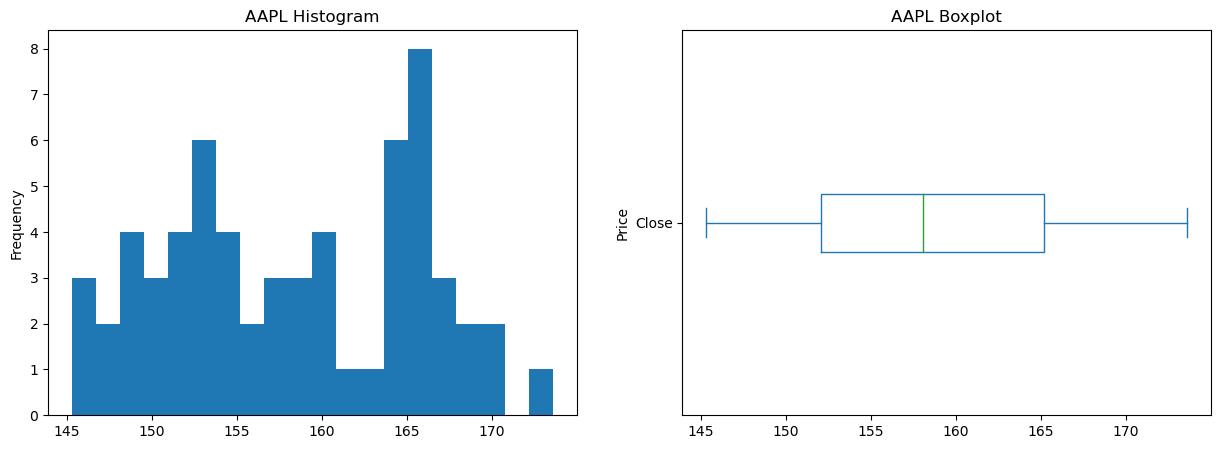

In [18]:
# Creating subplot
fig, axs = plt.subplots(nrows =1 , ncols =2 , figsize = (15,5))

# AAPL Histogram
AAPL['Close'].plot(kind = 'hist', bins = 20, ax = axs[0], title = 'AAPL Histogram')

# AAPL Boxplot 
AAPL['Close'].plot(kind = 'box', ax = axs[1], title = 'AAPL Boxplot',ylabel = 'Price', vert = False)

Despite the trimodal distribution in the histogram the AAPL 'Close' price dataset is evenly distributed as there is very little difference between the median and average.

In [50]:
# Creating new columns 'Month' and 'Year'

AAPL['Month'] = AAPL['Date'].dt.month

AAPL['Year'] = AAPL['Date'].dt.year

In [27]:
#viewing newly added columns, 'Month' and 'Year'

AAPL.head()

,Ticker,Date,Open,High,Low,Close,Adj_Close,Volume,Month,Year
0,AAPL,2023-02-07,150.64,155.23,150.64,154.65,154.41,83322600.0,2,2023
1,AAPL,2023-02-08,153.88,154.58,151.17,151.92,151.69,64120100.0,2,2023
2,AAPL,2023-02-09,153.78,154.33,150.42,150.87,150.64,56007100.0,2,2023
3,AAPL,2023-02-10,149.46,151.34,149.22,151.01,151.01,57450700.0,2,2023
4,AAPL,2023-02-13,150.95,154.26,150.92,153.85,153.85,62199000.0,2,2023


In [35]:
# Monthly AAPL Price Average

MoM_Price_Avg = AAPL.groupby(['Month', 'Year'])['Close'].mean()

print(MoM_Price_Avg)

Month  Year
2      2023    151.061333
3      2023    154.964783
4      2023    165.045789
5      2023    168.988000
Name: Close, dtype: float64


### Calculating the MoM_Price_Avg Monthly Price and Percentage Change in SQL

~~~ SQL
/*Temp Table*/
CREATE TEMP TABLE t1 AS
SELECT
  DISTINCT sub.Ticker, 
  sub.Month,
  sub.Year, 
  ROUND(AVG(Close) OVER (PARTITION BY sub.Month,sub.Year ),2) AS Monthly_Price_Avg
FROM
(SELECT 
  Ticker, 
  EXTRACT(MONTH FROM Date) AS Month, 
  EXTRACT(YEAR FROM Date) AS Year,
  Close
FROM `single-being-353600.Stock_Exploratory_Data_Analysis.Stock_Market` 
WHERE Ticker = 'AAPL') AS sub
ORDER BY sub.Month; -- subquery

/*MoM AAPL Calculations*/
SELECT
  t1.Ticker, 
  t1.Month, 
  t1.Year, 
  t1.Monthly_Price_Avg, 
  COALESCE(ROUND(t1.Monthly_Price_Avg - LAG(t1.Monthly_Price_Avg,1) OVER (ORDER BY t1.Month),2),0) AS MoM_Price_Change,
  COALESCE(ROUND((t1.Monthly_Price_Avg - LAG(t1.Monthly_Price_Avg,1) OVER (ORDER BY t1.Month)) / (LAG(t1.Monthly_Price_Avg,1) OVER (ORDER BY t1.Month)),2),0) * 100 AS MoM_Pct_Change
FROM t1
ORDER BY t1.Month;
~~~

**Result**

|Ticker|Month|Year|Monthly_Price_Avg|MoM_Price_Change|MoM_Pct_Change|
|---|---|---|---|---|---|
|AAPL|2|2023|151.06|0.0|0.0|
|AAPL|3|2023|154.96|3.9|3.0|
|AAPL|4|2023|165.05|10.09|7.0|
|AAPL|5|2023|168.99|3.94|2.0|


In [45]:
# Creating a dataframe with the results

AAPL_Dic = {
    'Ticker':['AAPL', 'AAPL', 'AAPL', 'AAPL'],
    'Month': [2,3,4,5],
    'Year': [2023,2023,2023,2023],
    'Monthly_Price_Avg': [151.06,154.96,165.05,168.99],
    'MoM_Price_Change': [0.0, 3.9,10.09,3.94],
    'MoM_Pct_Change': [0.0,3.0,7.0,2.0]}

AAPL_MoM_Metrics = pd.DataFrame(AAPL_Dic)

AAPL_MoM_Metrics = AAPL_MoM_Metrics.set_index(['Month','Year'])

print(AAPL_MoM_Metrics)

           Ticker  Monthly_Price_Avg  MoM_Price_Change  MoM_Pct_Change
Month Year                                                            
2     2023   AAPL             151.06              0.00             0.0
3     2023   AAPL             154.96              3.90             3.0
4     2023   AAPL             165.05             10.09             7.0
5     2023   AAPL             168.99              3.94             2.0


<Axes: title={'center': 'MoM Pct Change'}, xlabel='Month,Year', ylabel='Pct Change'>

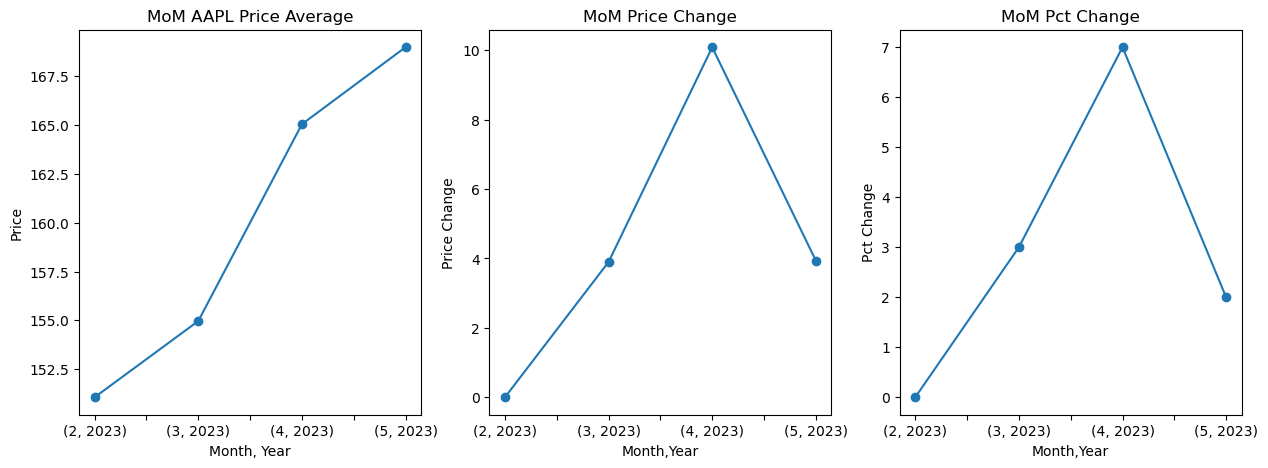

In [49]:
# creating subplots

fig,axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

# Plotting AAPL Metrics

MoM_Price_Avg.plot(kind = 'line', ax = axs[0], title = 'MoM AAPL Price Average', xlabel = 'Month, Year', ylabel = 'Price', marker = 'o')
AAPL_MoM_Metrics['MoM_Price_Change'].plot(kind = 'line', title = 'MoM Price Change', ax = axs[1], ylabel = 'Price Change', marker = 'o' )
AAPL_MoM_Metrics['MoM_Pct_Change'].plot(kind = 'line', title = 'MoM Pct Change', ax = axs[2], ylabel = 'Pct Change', marker = 'o' )


There was an upward trend of AAPL price aciton in the dataset. The largest spike in price action was from March 2023 to April 2023. There was a price increase of $10.09, a 7% MoM.